In [4]:
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
color_stg_d = {'C':'forestgreen','OC': 'yellowgreen', 'OD': 'indianred', 'D': 'maroon'}
color_stg_r = {'NR':'burlywood','RS': 'cornflowerblue', 'RA': 'orange', 'AR': 'midnightblue'}

In [6]:
def find_coplayer_rewarder_type(strategies, index):
    
    new_strategies = strategies.copy()
    
    new_strategies.pop(index)
    
    NR, SR, AR, UR = 0,0,0,0
    
    for i in range(0,len(new_strategies)):
        
        if new_strategies[i]%4 == 0:
            
            NR += 1
            
        elif new_strategies[i]%4 == 1:
            
            SR += 1
            
        elif new_strategies[i]%4 == 2:
            
            AR += 1
            
        else:
            
            UR += 1
            
    return NR,SR,AR,UR



def payoff_multiplayer_reward(strategies,coop_costs,reward_costs,informations,productivities,beta,):
    
    #returns payoffs and cooperation probabilities
    
    N = len(coop_costs)
    
    payoffs = {k:0 for k in range(0,N)}
    
    contribution_prob = {k:0 for k in range(0,N)}
    
    for i in contribution_prob:
        
        if strategies[i]<=3 and strategies[i]>=0:
            #C types
                
            contribution_prob[i] = 1
            
        elif strategies[i]<=15 and strategies[i]>=12:
            #D types
            
            contribution_prob[i] = 0
            
        elif strategies[i]<=7 and strategies[i]>=4:
            #OC types
            m_SR, m_AR = find_coplayer_rewarder_type(strategies, i)[1:3]
     
            if beta*(m_SR - m_AR) >= coop_costs[i]*(1-productivities[i]/N):
                contribution_prob[i] = 1
            else:
                contribution_prob[i] = 1-informations[i]
                
        else:
            #OD types
            
            m_SR, m_AR = find_coplayer_rewarder_type(strategies, i)[1:3]
     
            if beta*(m_SR - m_AR) >= coop_costs[i]*(1-productivities[i]/N):    
                contribution_prob[i] = informations[i] 
            else:
                contribution_prob[i] = 0
                
                
    total_contributions = sum([contribution_prob[i]*productivities[i]*coop_costs[i] for i in range(0,N)])
    
    for i in range(0,N):
        
        payoffs[i] += total_contributions/N - coop_costs[i]*contribution_prob[i]
    
    #paying costs of rewards
    #print(payoffs) 
    for i in payoffs: 
        
        if strategies[i]%4 == 3:
            #UR pays rewards for everyone
            
            payoffs[i] -= (N-1)*reward_costs[i]
            
        elif strategies[i]%4 == 2:
            #AR pays rewards for defection
            
            payoffs[i] -= sum([1-contribution_prob[j] for j in range(0,N) if j not in [i]])*reward_costs[i]
            
        elif strategies[i]%4 == 1:
            #SR pays rewards for cooperation
            
            payoffs[i] -= sum([contribution_prob[j] for j in range(0,N) if j not in [i]])*reward_costs[i]
            
        
    #getting back benefits of rewards:
    #print(payoffs)
    for i in payoffs: 
        
        m_SR, m_AR, m_UR = find_coplayer_rewarder_type(strategies, i)[1:] 
        
        payoffs[i] += m_UR*beta + m_SR*contribution_prob[i]*beta + m_AR*(1-contribution_prob[i])*beta
        
   
    return payoffs, contribution_prob
            
                 

In [7]:
#payoff_multiplayer_reward(strategies,coop_costs,reward_costs,informations,productivities,beta,)
payoff_multiplayer_reward([0,5,5,11],[1,1,1,1],[0.1,0.1,0.1,0.1],[0.4,0.4,0.4,0.4],[2,2,2,2],0.5)

({0: 2.2, 1: 1.46, 2: 1.46, 3: 1.4}, {0: 1, 1: 1, 2: 1, 3: 0.4})

In [8]:
def get_introspection_probabilities(index,new_strategy_for_index,selection,strategies,coop_costs,reward_costs,informations,productivities,beta,):
    
    
    vals = payoff_multiplayer_reward(strategies,coop_costs,reward_costs,informations,productivities,beta,)
    
    curr_payoff, curr_cooperation = vals[0][index], vals[1]
    
    new_strategy_set = strategies[:index] + [new_strategy_for_index] + strategies[index+1:] 

    new_payoff = payoff_multiplayer_reward(new_strategy_set,coop_costs,reward_costs,informations,productivities,beta,)[0][index]

    prob_shifting = 1/(1+math.exp(-selection*(new_payoff - curr_payoff)))
    
    #print(new_payoff,curr_payoff)

    #probs[curr_strategy] = 1-sum(probs)
    
    return prob_shifting,curr_cooperation
            

In [9]:
#args = selection,strategies,coop_costs,reward_costs,informations,productivities,beta

args = (10, [0]*3, [1]*3, [0.05,0.1,0.15], [0.5]*3,[2]*3,0.5)

get_introspection_probabilities(0,5,*args)

(0.6607563687658171, {0: 1, 1: 1, 2: 1})

#### run the introspection dynamics simualtion and capture the average number of time each player spends in each strategy

In [10]:
def simulate_introspection(T,N,selection,coop_costs,reward_costs, information, productivities, beta):


    init_stgs = list(np.random.randint(0,16,N))

    stgs_visited = {k:[0]*16 for k in range(0,N)}

    coop = {k:[] for k in range(0,N)}
    
    coops = [0]*N

    stgs = init_stgs

    for t in range(0,T):

        player_picked = random.choice(list(range(0,N)))
        curr_stg = stgs[player_picked]
        stg_picked = random.choice(list(range(0,curr_stg)) + list(range(curr_stg+1,16)))

        #args = selection,strategies,coop_costs,reward_costs,informations,productivities,beta
        args = (selection, stgs, coop_costs, reward_costs, information,productivities,beta)
        

        vals = get_introspection_probabilities(player_picked,stg_picked,*args)

        prob,curr_coop = vals[0], vals[1]

        new_stg = np.random.choice([curr_stg,stg_picked],p=[1-prob,prob])
        stgs[player_picked] = new_stg
        
        

        for i in range(0,N):
            stgs_visited[i][stgs[i]] += 1 
            coop[i].append(curr_coop[i]) 

        #print(stgs)

    for i in stgs_visited:
        stgs_visited[i] = [j/T for j in stgs_visited[i]]
    
    for i in coop:
        coops[i] = sum(coop[i])/T
        
    return stgs_visited,coops

#print(stgs_visited)

### how did I choose parameters here:

#### this section describes how I choose the parameters for asymmetry:

N = 3 (freedom here)

c = 1 (freedom taken here)

$r_L = 1.2, r_H = 2$ (freedom here too)

$\gamma_{H} = 0.5, \gamma_L = 0.1$ are chosen to assure that $\gamma_L$ makes rewarding worth for both $r_H, r_L$ players and $\gamma_H$ is too high for either players to reward.

$\beta = 0.7$ assures that $r_L$ opportunists needs only one SR to cooperate

$\beta = 0.35$ assures that $r_L$ opportunists need both co-players to be SR to cooperate

$\lambda_L = 0.1$ is chosen such that $\lambda_L < \gamma_L N/c r_H$

$\lambda_H = 0.9$ is chosen such that $\lambda_H > \gamma_H N/c r_L$

In [280]:
N,T = 3,10**5
coop_costs = [1]*N
selection = 10
beta = 0.35

reward_costs = [0.1,0.1,0.1]
information = [0.9,0.9,0.9]
productivity = [2,2,1.2]

stgs_visited, coop = simulate_introspection(T,N,10,coop_costs,reward_costs,information,productivity,beta)



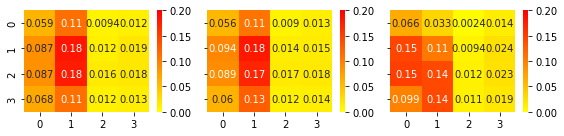

In [281]:
fig,ax = plt.subplots(1,3,figsize = (8,2),sharey = True)
sns.heatmap(np.array(stgs_visited[0]).reshape(4,4),ax = ax[0],cmap = 'autumn_r',vmax = 0.2, vmin = 0,annot = True)
sns.heatmap(np.array(stgs_visited[1]).reshape(4,4),ax = ax[1],cmap = 'autumn_r',vmax = 0.2, vmin = 0,annot=True)
sns.heatmap(np.array(stgs_visited[2]).reshape(4,4),ax = ax[2],cmap = 'autumn_r',vmax = 0.2, vmin = 0,annot = True)
plt.tight_layout()

#### bar plot of NR, SR and cooperation

<ipython-input-282-420f0bfd71d5>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)


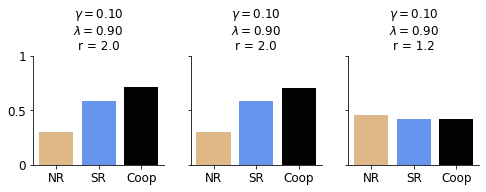

In [282]:
fontsize = 12

nr_list = [sum(np.array(stgs_visited[k]).reshape(4,4)[:,0]) for k in range(0,N)]
sr_list = [sum(np.array(stgs_visited[k]).reshape(4,4)[:,1]) for k in range(0,N)]


heights = []
for i in range(0,N):
    heights.append([nr_list[i],sr_list[i],coop[i]])
    
fig,ax = plt.subplots(1,3,figsize=(8,2),sharey = True)


max_y = 1
ax[0].set_ylim([0,max_y])
xpos = [0,1,2]
for i in range(0,N):
    ax[i].bar(xpos, heights[i], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
    ax[i].bar(xpos, heights[i], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
    ax[i].bar(xpos, heights[i], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_yticks([0,0.5,1])
    ax[i].set_yticklabels([0,0.5,1],fontsize = fontsize)
    ax[i].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)
    ax[i].set_title('$\gamma = %.2f$'%reward_costs[i] + '\n' + '$\lambda = %.2f$'%information[i] + '\n' + 'r = %.1f'%productivity[i])

## figure with all asymmetries

In [283]:
N,T = 3,10**5
coop_cost_list = [[1]*N,[1]*N,[0.5]*N]
reward_cost_list = [[0.1,0.1,0.7],[0.1]*N,[0.1]*N]
productivity_list = [[2]*N, [2,2,1.2], [2]*N]
information_list = [[0.9]*N, [0.9]*N, [0.9,0.9,0.1]]

selection = 10
beta = 0.3

stgs_visited_list = []
coop_list = []

for i in range(0,3):
    
    N,T = 3,10**5
    
    coop_costs = coop_cost_list[i]
    reward_costs = reward_cost_list[i]
    information = information_list[i]
    productivity = productivity_list[i]
    
    stgs_visited, coop = simulate_introspection(T,N,10,coop_costs,reward_costs,information,productivity,beta)
    
    stgs_visited_list.append(stgs_visited)
    coop_list.append(coop)

In [284]:
coop_list

[[0.28405299999992223, 0.275483999999943, 0.6331870000001243],
 [0.6199390000001285, 0.6296560000001187, 0.13232700000006156],
 [0.6642550000001537, 0.6750410000001258, 0.47461499999999207]]

<ipython-input-286-e717a1a5a8f3>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][0].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)
<ipython-input-286-e717a1a5a8f3>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][1].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)


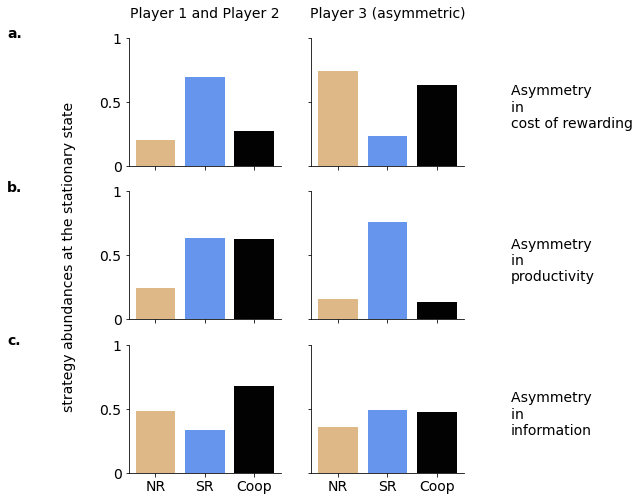

In [286]:
fontsize = 14

fig,ax = plt.subplots(3,2,figsize=(6,8),sharey = True, sharex = True)

for i in range(0,3):
    
    nr_list = [sum(np.array(stgs_visited_list[i][k]).reshape(4,4)[:,0]) for k in range(0,N)]
    sr_list = [sum(np.array(stgs_visited_list[i][k]).reshape(4,4)[:,1]) for k in range(0,N)]
    coop = coop_list[i]
    
    heights = []
    for j in range(0,N):
        heights.append([nr_list[j],sr_list[j],coop[j]])
        
    #print(heights)
    max_y = 1
    axn[i][0].set_ylim([0,max_y])
    xpos = [0,1,2]
    for j in range(0,N-1):

        ax[i][j].bar(xpos, heights[j+1], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
        ax[i][j].bar(xpos, heights[j+1], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
        ax[i][j].bar(xpos, heights[j+1], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].set_yticks([0,0.5,1])
        ax[i][j].set_yticklabels([0,0.5,1],fontsize = fontsize)
        
ax[0][0].set_title('Player 1 and Player 2', fontsize = fontsize,pad = 20)
ax[0][1].set_title('Player 3 (asymmetric)', fontsize = fontsize,pad = 20)
ax[0][1].text(3.5,0.3,'Asymmetry \nin \ncost of rewarding', fontsize = fontsize)
ax[1][1].text(3.5,0.3,'Asymmetry \nin \nproductivity', fontsize = fontsize)
ax[2][1].text(3.5,0.3,'Asymmetry \nin \ninformation', fontsize = fontsize)

ax[0][0].text(-3,1,'a.', fontsize = fontsize, weight = 'bold')
ax[1][0].text(-3,1,'b.', fontsize = fontsize, weight = 'bold')
ax[2][0].text(-3,1,'c.', fontsize = fontsize, weight = 'bold')

ax[2][0].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)
ax[2][1].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)

fig.text(-0.03, 0.5, 'strategy abundances at the stationary state', va='center', rotation='vertical', fontsize = fontsize)


plt.savefig('asymmetry_figure.pdf',bbox_inches='tight')
plt.show()



### all three unequal - one low, one high, one intermediate

In [32]:
N,T = 3,10**5
coop_costs = [1]*N
selection = 10
beta = 0.5


delta_gamma, delta_lmd, delta_r = 0.5,0,0

reward_costs = [0.1*(1-delta_gamma),0.1,0.1*(1+delta_gamma)]
information = [0.5*(1-delta_lmd),0.5,0.5*(1+delta_lmd)]
productivity = [2*(1-delta_r),2,2*(1+delta_r)]

stgs_visited, coop = simulate_introspection(T,N,10,coop_costs,reward_costs,information,productivity, 0.6)



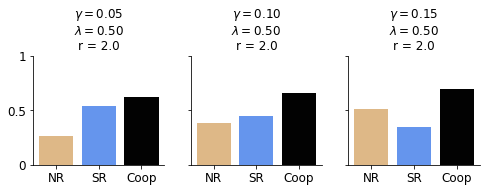

In [33]:
fontsize = 12

nr_list = [sum(np.array(stgs_visited[k]).reshape(4,4)[:,0]) for k in range(0,N)]
sr_list = [sum(np.array(stgs_visited[k]).reshape(4,4)[:,1]) for k in range(0,N)]


heights = []
for i in range(0,N):
    heights.append([nr_list[i],sr_list[i],coop[i]])
    
fig,ax = plt.subplots(1,3,figsize=(8,2),sharey = True)


max_y = 1
ax[0].set_ylim([0,max_y])


for i in range(0,N):
    ax[i].bar(xpos, heights[i], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
    ax[i].bar(xpos, heights[i], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
    ax[i].bar(xpos, heights[i], color = [color_stg_r['NR'],color_stg_r['RS'],'black'], alpha = 0.8)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_yticks([0,0.5,1])
    ax[i].set_yticklabels([0,0.5,1],fontsize = fontsize)
    ax[i].set_xticklabels(['','NR','SR','Coop'],fontsize = fontsize)
    ax[i].set_title('$\gamma = %.2f$'%reward_costs[i] + '\n' + '$\lambda = %.2f$'%information[i] + '\n' + 'r = %.1f'%productivity[i])

In [109]:
import scipy.special

scipy.special.binom(4, 2)

6.0

## fun for TAC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


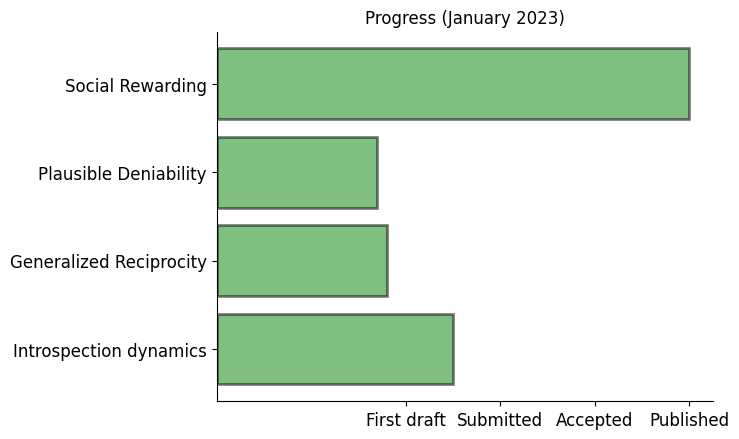

In [330]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
fontsize = 12

plt.rcdefaults()


fig,ax = plt.subplots()

# Example data
people = ('Social Rewarding', 'Plausible Deniability', 'Generalized Reciprocity', 'Introspection dynamics')
y_pos = np.arange(len(people))
performance = [10,3.4,3.6,5]
error = np.random.rand(len(people))

ax.barh(y_pos, performance, align='center',alpha = 0.5, color = 'green',edgecolor = 'k',linewidth = 2)
ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticklabels(people,fontsize = fontsize)
ax.set_xticks([4,6,8,10])
ax.set_xticklabels(['First draft', 'Submitted','Accepted','Published'],fontsize = fontsize)
ax.set_title('Progress (January 2023)')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('January_progress.eps',bbox_inches = 'tight')
plt.show()